# Chapter 7 Investigation of Cross-Frequency Coupling in a Local Field Potential

## Step 1 Visual inspection

### Load the data

In [1]:
load('Ch7-LFP-1.mat')

### Plot LFP

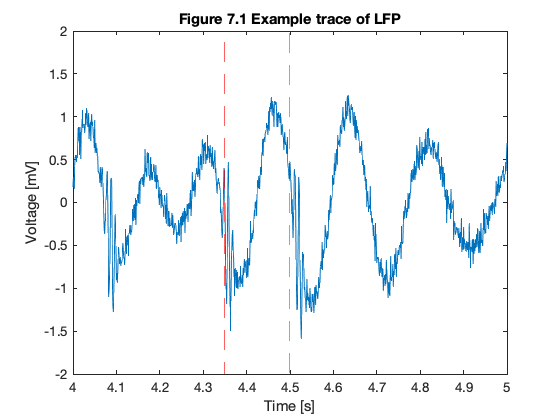

In [2]:
figure
plot(t, LFP)
axis([4 5 -2 2])
hold on
plot(ones(2, 1) * [4.35, 4.5], ylim' * ones(1, 2), 'r--')
xlabel('Time [s]')
ylabel('Voltage [mV]')
title('Figure 7.1 Example trace of LFP')

## Step 2 Estimate power spectrum

### 2.1 Using classic FFT

In [3]:
dt=t(2)-t(1);
Fs=1/dt;
fNQ = Fs / 2;
T=t(end);
N=length(LFP);

#### estimate FFT using Hanning window

In [4]:
x = hann(N) .* transpose(LFP);
xf = fft(x - mean(x)); % zero-mean process
Sxx = 2 * dt^2 / T * (xf .* conj(xf));
Sxx = Sxx(1:N / 2 + 1);

#### plot the power spectrum

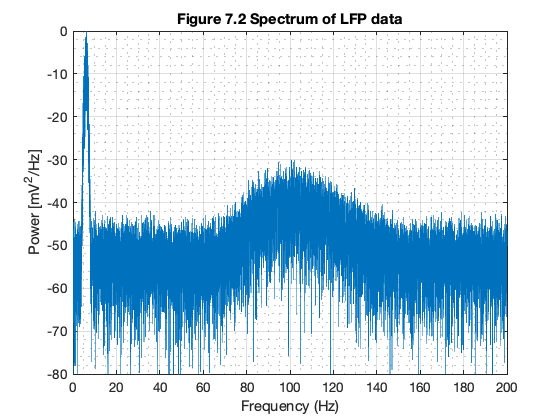

In [5]:
df = 1 / max(T);
faxis = (0:df:fNQ);
figure
plot(faxis, 10 * log10(Sxx))
xlim([0 200])
ylim([-80 0])
grid on
grid minor
xlabel('Frequency (Hz)')
ylabel('Power [mV^2/Hz]')
title('Figure 7.2 Spectrum of LFP data')

### 2.2 Using multitaper method to estimate spectrum

#### add directories

* on cortex

In [6]:
addpath(genpath('~/Documents/Richard/Projects/rochester/mayo_clinic/nonuniform_signal'))

#### estimate spectrum

In [7]:
import mtnusp.NUContinuous

TW = 40;
f_qf = 0:.1:fNQ / 2;
nus = NUContinuous(x - mean(x), t);
J = nus.mtnufft('QuerryFrequencies', f_qf, 'TimeHalfbandwidth', TW);
J = J / 3.5/10;

#### plot

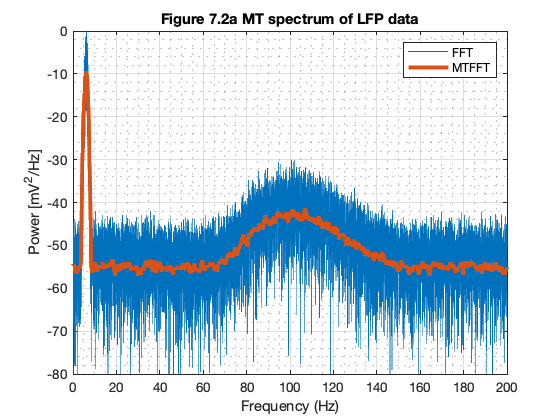

In [8]:
pxx = mean(J .* conj(J), 2);
figure
h_fft = plot(faxis, pow2db(Sxx));
hold on
h_mt = plot(f_qf, pow2db(pxx), 'LineWidth', 3);
xlim([0 200])
ylim([-80 0])
grid on
grid minor
legend([h_fft, h_mt], ["FFT", "MTFFT"])
xlabel('Frequency (Hz)')
ylabel('Power [mV^2/Hz]')
title('Figure 7.2a MT spectrum of LFP data')

#### F-test of periodicity

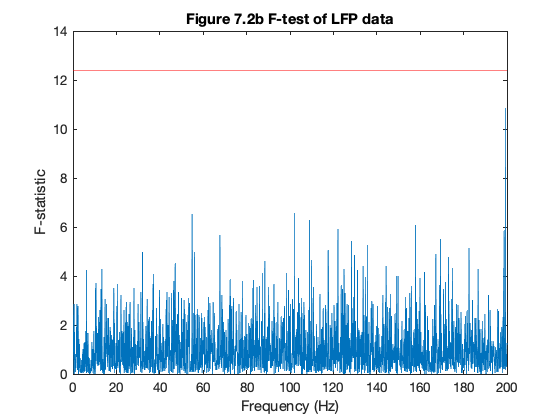

In [9]:
Fval = nus.nuftest(QuerryFrequencies = f_qf, TimeHalfbandwidth = TW);
Nr = 2 * fNQ / df;
K = 2 * TW - 1;
sig = finv(1 - 1 / Nr, 2, 2 * K - 2);

figure
plot(f_qf, Fval)
hold on
plot(xlim, ones(1, 2) * sig, 'r')
xlim([0, 200])
xlabel('Frequency (Hz)')
ylabel('F-statistic')
title('Figure 7.2b F-test of LFP data')

## Step 3 Cross-frequency coupling

### Filtering the data into high- and low-frequency bands

#### for low-frequency interval

In [10]:
Wn = [5, 7] / fNQ; % set the passband
n = 100; % filter order
b = fir1(n, Wn);
Vlo = filtfilt(b, 1, LFP); % apply the filter

#### for high-frequency interval

In [11]:
Wn = [80, 120] / fNQ;
b = fir1(n, Wn);
Vhi = filtfilt(b, 1, LFP);

#### plot Figure 7.3

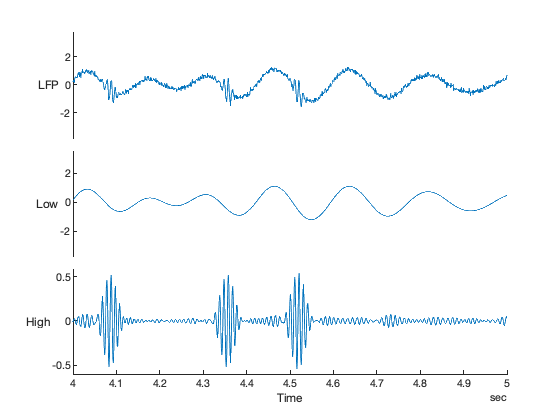

In [12]:
D = timetable(LFP', Vlo', Vhi', 'RowTimes', seconds(t'), ...
'VariableNames', ["LFP", "Low", "High"]); % make the timetable

% stacked plot
figure
stackedplot(D)
xlim(seconds([4 5]))

### plot Figure 7.4 

In [13]:
phi = angle(hilbert(Vlo)); % compute phase of low frequency signal
amp = abs(hilbert(Vhi)); % compute amplitude of high frequency signal

#### plot Figure 7.4a

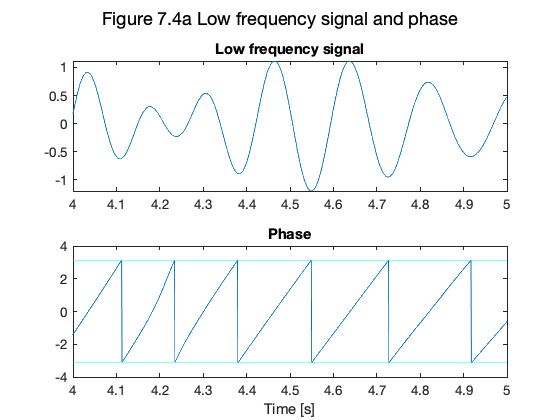

In [14]:
figure
ax_lo = subplot(2, 1, 1);
plot(t, Vlo)
title('Low frequency signal')

ax_hi = subplot(2, 1, 2);
plot(t, phi);
hold on
plot(xlim' * ones(1, 2), ones(2, 1) * [-1, 1] * pi, 'c')
xlabel('Time [s]')
title('Phase')

linkaxes([ax_lo, ax_hi], 'x')
xlim([4 5])
sgtitle('Figure 7.4a Low frequency signal and phase')


#### plot Figure 7.4b

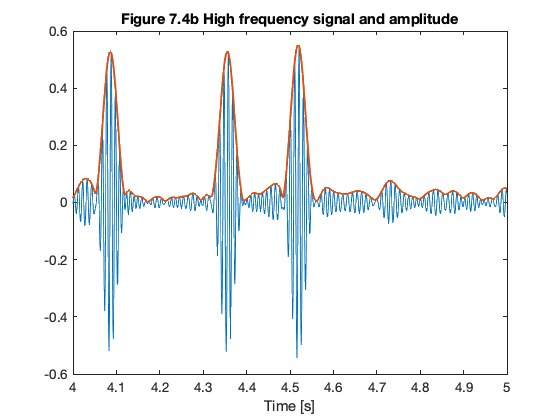

In [15]:
figure
plot(t, Vhi)
hold on
plot(t, amp, 'LineWidth', 2)
xlim([4 5])
xlabel('Time [s]')
title('Figure 7.4b High frequency signal and amplitude')

### Determine if the phase and Amplitude are related

#### Method-1: Phase-amplitude plot

In [16]:
p_bins = -pi:.1:pi;
a_mean = zeros(length(p_bins) - 1, 1);
p_mean = zeros(length(p_bins) - 1, 1);

In [20]:
for k = 1:length(p_bins) - 1
    pL = p_bins(k);
    pR = p_bins(k + 1);
    indices = find(phi >= pL & phi < pR);
    a_mean(k) = mean(amp(indices));
    p_mean(k) = mean([pL, pR]);
end % for

% Difference between max and min modulation
h=max(a_mean)-min(a_mean);

#### plot Figure 7.7

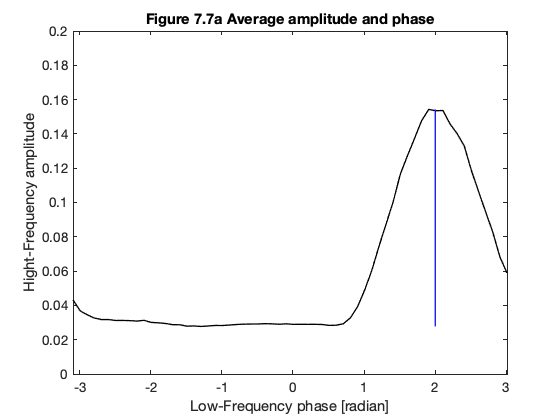

In [27]:
figure

plot(p_mean, a_mean, 'k', LineWidth = 1)
hold on
plot([2 2], [max(a_mean) - h, max(a_mean)], 'b', LineWidth = 1)
xlim tight
ylim([0 .2])
xlabel('Low-Frequency phase [radian]')
ylabel('Hight-Frequency amplitude')
title('Figure 7.7a Average amplitude and phase')


In [31]:
n_surrogates = 1000;
hS = zeros(n_surrogates, 1);

for ns = 1:n_surrogates
    ampS = amp(randperm(length(amp)));
    p_bins = -pi:.1:pi;
    a_mean = zeros(length(p_bins) - 1, 1);
    p_mean = zeros(length(p_bins) - 1, 1);

    for k = 1:length(p_bins) - 1
        pL = p_bins(k);
        pR = p_bins(k + 1);
        indeces = find(phi >= pL & phi <= pR);
        a_mean(k) = mean(ampS(indeces));
        p_mean(k) = mean([pL, pR]);
    end % for

    hS(ns) = max(a_mean) - min(a_mean);

end % for

p = length(find(hS > h)) / length(hS); % p-value
fprintf('p-value: %.4f\n', p)


p-value: 0.0000


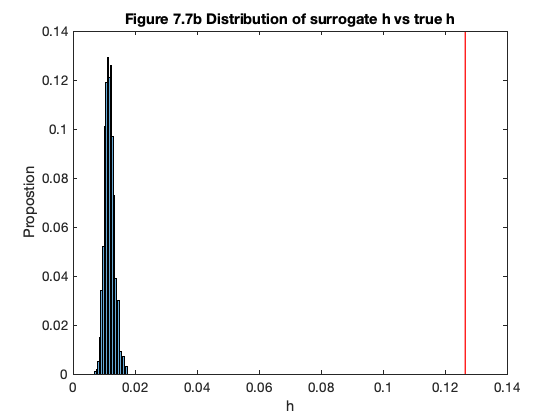

In [41]:
figure

histogram(hS, 'Normalization', 'probability');
hold on
plot(ones(1, 2) * h, ylim, 'r', 'linewidth', 1)
xlim([0 0.14])
xlabel('h')
ylabel('Propostion')
title('Figure 7.7b Distribution of surrogate h vs true h')


### Method 2: GLM approach